# **Import Data**

In [1]:
!pip install torchviz

  Preparing metadata (setup.py) ... - done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4131 sha256=fe97424641d9ea0b9398f5f53f403938e7a53305b30232904e9d97a5c7f4bac8
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [2]:
import warnings
warnings.filterwarnings("ignore")
import glob
import random
import shutil
import os
import cv2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


import torch
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,Dataset
import torch.optim as optim
from torchinfo import summary
from PIL import Image
from tensorflow.keras.applications import imagenet_utils

import colorama
from colorama import Fore, Style


from torchviz import make_dot
from IPython.display import Image

2024-08-23 16:01:03.824389: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-23 16:01:03.824519: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-23 16:01:04.003333: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
data_path = "/kaggle/input/rice-image-dataset/Rice_Image_Dataset"     


arborio = glob.glob(data_path + '/Arborio/*')
basmati = glob.glob(data_path + '/Basmati/*')
ipsala = glob.glob(data_path + '/Ipsala/*')
jasmine = glob.glob(data_path + '/Jasmine/*')
karacadag = glob.glob(data_path + '/Karacadag/*')

In [4]:
print (len(arborio))
print (len(basmati))
print (len(ipsala))
print (len(jasmine))
print (len(karacadag))

15000
15000
15000
15000
15000


# **Show Sample Images**

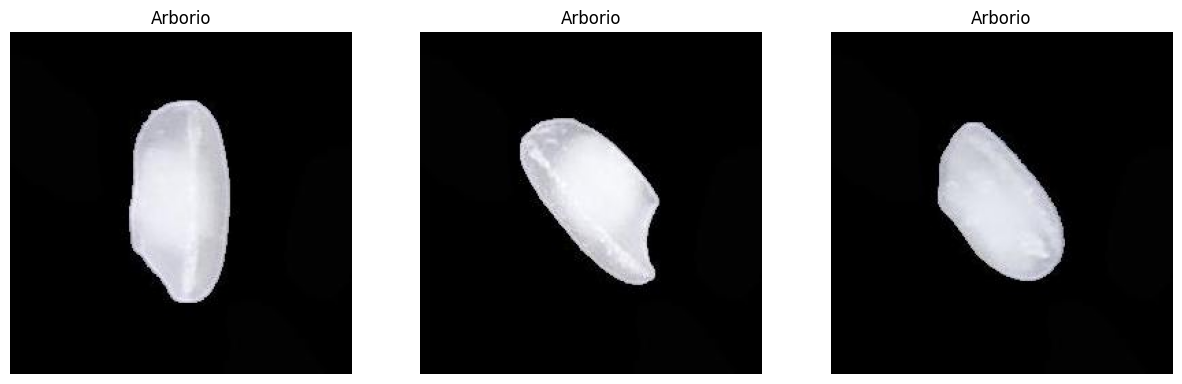

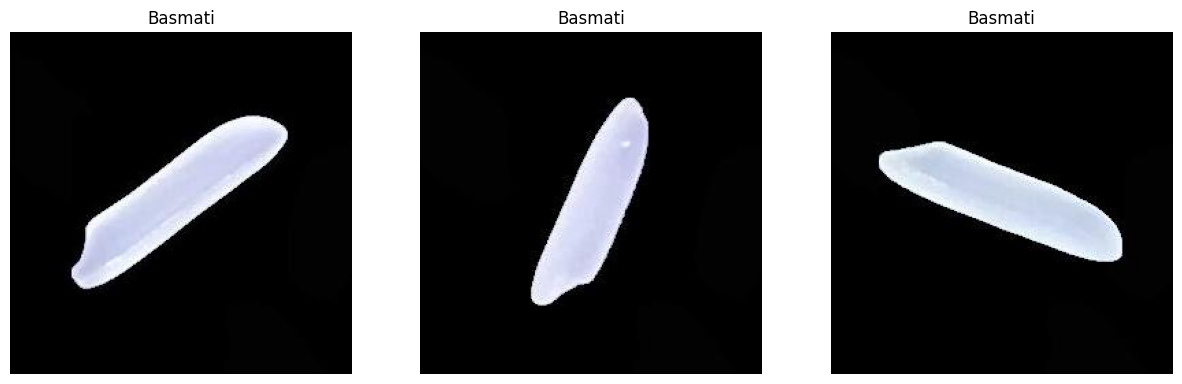

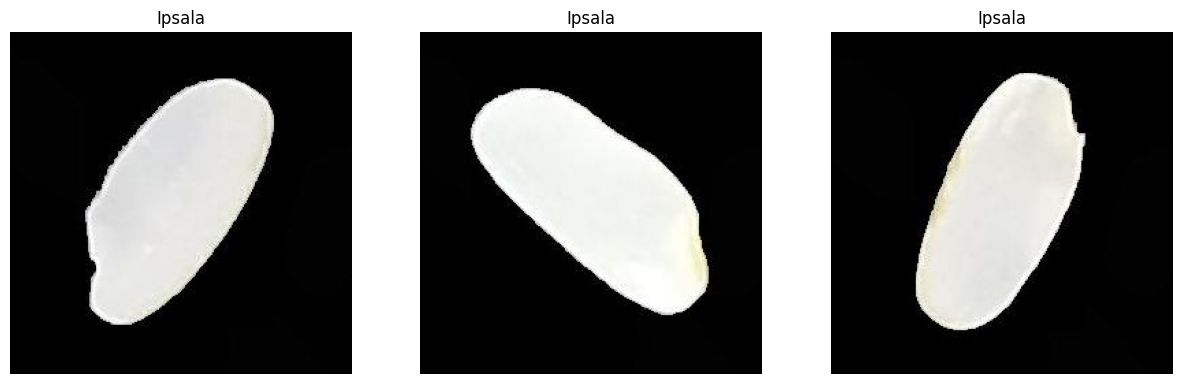

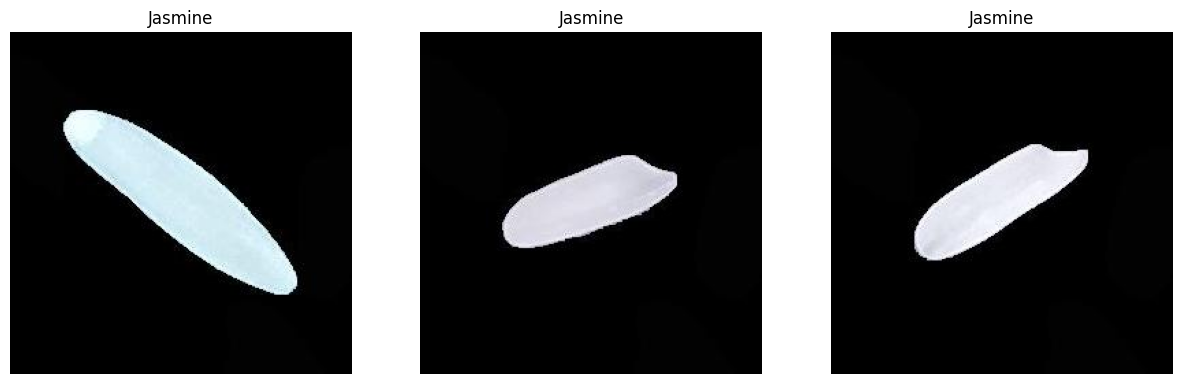

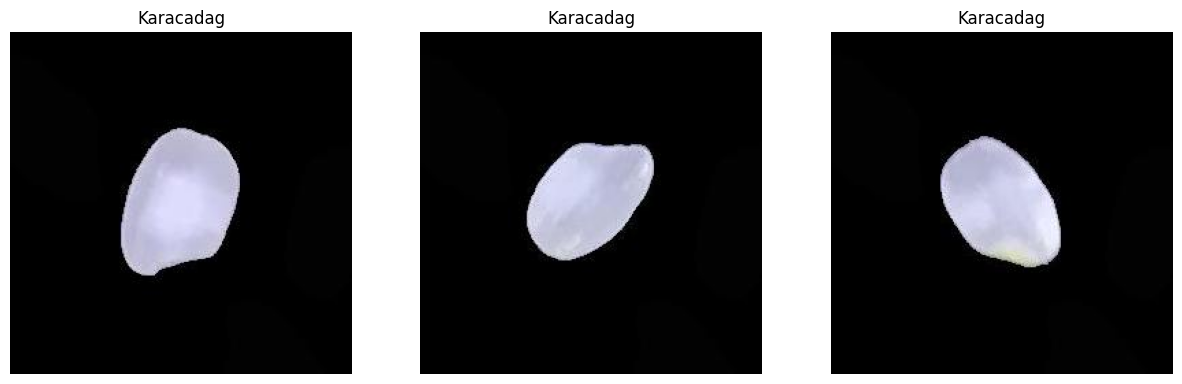

In [5]:
# Function to display images
def show_images(image_list, title):
    plt.figure(figsize=(15, 10))
    for i in range(3):  # Display 5 images
        plt.subplot(1, 3, i + 1)
        img = mpimg.imread(random.choice(image_list))  # Randomly choose an image from the list
        plt.imshow(img)
        plt.title(title)
        plt.axis('off')
    plt.show()

# Display images from each category
show_images(arborio, "Arborio")
show_images(basmati, "Basmati")
show_images(ipsala, "Ipsala")
show_images(jasmine, "Jasmine")
show_images(karacadag, "Karacadag")

In [6]:
data_path_image_list_ = "/kaggle/input/rice-image-dataset/Rice_Image_Dataset"

print(.8*len((glob.glob(data_path_image_list_ + '/Arborio/*'))) , .15*len((glob.glob(data_path_image_list_ + '/Arborio/*'))) ,.05*len((glob.glob(data_path_image_list_ + '/Arborio/*'))))
print(.8*len((glob.glob(data_path_image_list_ + '/Basmati/*'))) , .15*len((glob.glob(data_path_image_list_ + '/Basmati/*'))) ,.05*len((glob.glob(data_path_image_list_ + '/Basmati/*'))))
print(.8*len((glob.glob(data_path_image_list_ + '/Ipsala/*'))) , .15*len((glob.glob(data_path_image_list_ + '/Ipsala/*'))) ,.05*len((glob.glob(data_path_image_list_ + '/Ipsala/*'))))
print(.8*len((glob.glob(data_path_image_list_ + '/Jasmine/*'))) , .15*len((glob.glob(data_path_image_list_ + '/Jasmine/*'))) ,.05*len((glob.glob(data_path_image_list_ + '/Jasmine/*'))))
print(.8*len((glob.glob(data_path_image_list_ + '/Karacadag/*'))) , .15*len((glob.glob(data_path_image_list_ + '/Karacadag/*'))) ,.05*len((glob.glob(data_path_image_list_ + '/Karacadag/*'))))

12000.0 2250.0 750.0
12000.0 2250.0 750.0
12000.0 2250.0 750.0
12000.0 2250.0 750.0
12000.0 2250.0 750.0


In [7]:
print("Train", "Test", "Valid")

# Assuming arborio, basmati, ipsala, jasmine, and karacadag are defined lists or arrays
rice_types = {
    "arborio": arborio,
    "basmati": basmati,
    "ipsala": ipsala,
    "jasmine": jasmine,
    "karacadag": karacadag
}

splits = {}
for rice_type, data in rice_types.items():
    train_data = data[:12000]
    test_data = data[12000:14250]
    valid_data = data[14250:]
    
    splits[rice_type] = {
        "train": train_data,
        "test": test_data,
        "valid": valid_data
    }

    print(f"{rice_type.capitalize()} - Train: {len(train_data)}, Test: {len(test_data)}, Valid: {len(valid_data)}")

Train Test Valid
Arborio - Train: 12000, Test: 2250, Valid: 750
Basmati - Train: 12000, Test: 2250, Valid: 750
Ipsala - Train: 12000, Test: 2250, Valid: 750
Jasmine - Train: 12000, Test: 2250, Valid: 750
Karacadag - Train: 12000, Test: 2250, Valid: 750


In [8]:
# Assuming train_arborio, train_basmati, train_ipsala, train_jasmine, and train_karacadag are defined lists or arrays
train_data = {
    'arborio': arborio[:12000], 
    'basmati': basmati[:12000],
    'ipsala': ipsala[:12000],
    'jasmine': jasmine[:12000],
    'karacadag': karacadag[:12000]
}

train_dfs = {}
for label, images in train_data.items():
    train_dfs[label] = pd.DataFrame({'image': images, 'label': label})

# Access individual DataFrames
train_arborio_df = train_dfs['arborio']
train_basmati_df = train_dfs['basmati']
train_ipsala_df = train_dfs['ipsala']
train_jasmine_df = train_dfs['jasmine']
train_karacadag_df = train_dfs['karacadag']

In [9]:
# Assuming test_arborio, test_basmati, test_ipsala, test_jasmine, and test_karacadag are defined lists or arrays
test_data = {
    'arborio': arborio[12000:14250],  
    'basmati': basmati[12000:14250],
    'ipsala': ipsala[12000:14250],
    'jasmine': jasmine[12000:14250],
    'karacadag': karacadag[12000:14250]
}

test_dfs = {}
for label, images in test_data.items():
   test_dfs[label] = pd.DataFrame({'image': images, 'label': label})

# Access individual DataFrames
test_arborio_df = test_dfs['arborio']
test_basmati_df = test_dfs['basmati']
test_ipsala_df = test_dfs['ipsala']
test_jasmine_df = test_dfs['jasmine']
test_karacadag_df = test_dfs['karacadag']

In [10]:
# Assuming valid_arborio, valid_basmati, valid_ipsala, valid_jasmine, and valid_karacadag are defined lists or arrays
valid_data = {
    'arborio': arborio[14250:],  
    'basmati': basmati[14250:],
    'ipsala': ipsala[14250:],
    'jasmine': jasmine[14250:],
    'karacadag': karacadag[14250:]
}

valid_dfs = {}
for label, images in valid_data.items():
   valid_dfs[label] = pd.DataFrame({'image': images, 'label': label})

# Access individual DataFrames
valid_arborio_df = valid_dfs['arborio']
valid_basmati_df = valid_dfs['basmati']
valid_ipsala_df = valid_dfs['ipsala']
valid_jasmine_df = valid_dfs['jasmine']
valid_karacadag_df = valid_dfs['karacadag']


In [11]:
# Assuming train_arborio_df, train_basmati_df, etc., are already defined

try:
    train_df = pd.concat([train_arborio_df, train_basmati_df, train_ipsala_df, train_jasmine_df, train_karacadag_df])
    test_df = pd.concat([test_arborio_df, test_basmati_df, test_ipsala_df, test_jasmine_df, test_karacadag_df])
    valid_df = pd.concat([valid_arborio_df, valid_basmati_df, valid_ipsala_df, valid_jasmine_df, valid_karacadag_df])
    print("DataFrames concatenated successfully.")
except Exception as e:
    print(f"An error occurred during concatenation: {e}")

DataFrames concatenated successfully.


In [12]:
test_df.head(30)

,image,label
0,/kaggle/input/rice-image-dataset/Rice_Image_Da...,arborio
1,/kaggle/input/rice-image-dataset/Rice_Image_Da...,arborio
2,/kaggle/input/rice-image-dataset/Rice_Image_Da...,arborio
3,/kaggle/input/rice-image-dataset/Rice_Image_Da...,arborio
4,/kaggle/input/rice-image-dataset/Rice_Image_Da...,arborio
5,/kaggle/input/rice-image-dataset/Rice_Image_Da...,arborio
6,/kaggle/input/rice-image-dataset/Rice_Image_Da...,arborio
7,/kaggle/input/rice-image-dataset/Rice_Image_Da...,arborio
8,/kaggle/input/rice-image-dataset/Rice_Image_Da...,arborio
9,/kaggle/input/rice-image-dataset/Rice_Image_Da...,arborio


In [13]:
print("Number of rows in train dataframe is: ", len(train_df))
print("Number of rows in test dataframe is: ", len(test_df))
print("Number of rows in validation dataframe is: ", len(valid_df))

Number of rows in train dataframe is:  60000
Number of rows in test dataframe is:  11250
Number of rows in validation dataframe is:  3750


In [14]:

# Define your image transformations here
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a consistent size
    transforms.ToTensor(),          # Convert images to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize pixel values
])

# Modify the CustomDataset class to convert labels to indices
class CustomDataset(Dataset):
    def __init__(self, df, transform=None, class_names=None):
        self.df = df
        self.transform = transform
        self.class_names = class_names

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx, 0]  # Assuming the first column has image paths
        label = self.df.iloc[idx, 1]  # Assuming the second column has labels
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error opening image {img_path}: {e}")
            return None, None
        if self.transform:
            image = self.transform(image)
        try:
            label_idx = self.class_names.index(label)
        except ValueError as e:
            print(f"Error converting label {label} to index: {e}")
            return None, None
        return image, label_idx

# Assuming 'class_names' is defined somewhere, replace with your actual class names
class_names = ['arborio', 'basmati', 'ipsala', 'jasmine', 'karacadag']

# Create datasets with the updated CustomDataset class
train_dataset = CustomDataset(train_df, transform=transform, class_names=class_names)
test_dataset  = CustomDataset(test_df, transform=transform, class_names=class_names)
valid_dataset = CustomDataset(valid_df, transform=transform, class_names=class_names)

# Create dataloaders as before
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

Label: arborio (0)
Label: arborio (0)
Label: arborio (0)
Label: basmati (1)
Label: basmati (1)
Label: basmati (1)
Label: ipsala (2)
Label: jasmine (3)
Label: karacadag (4)


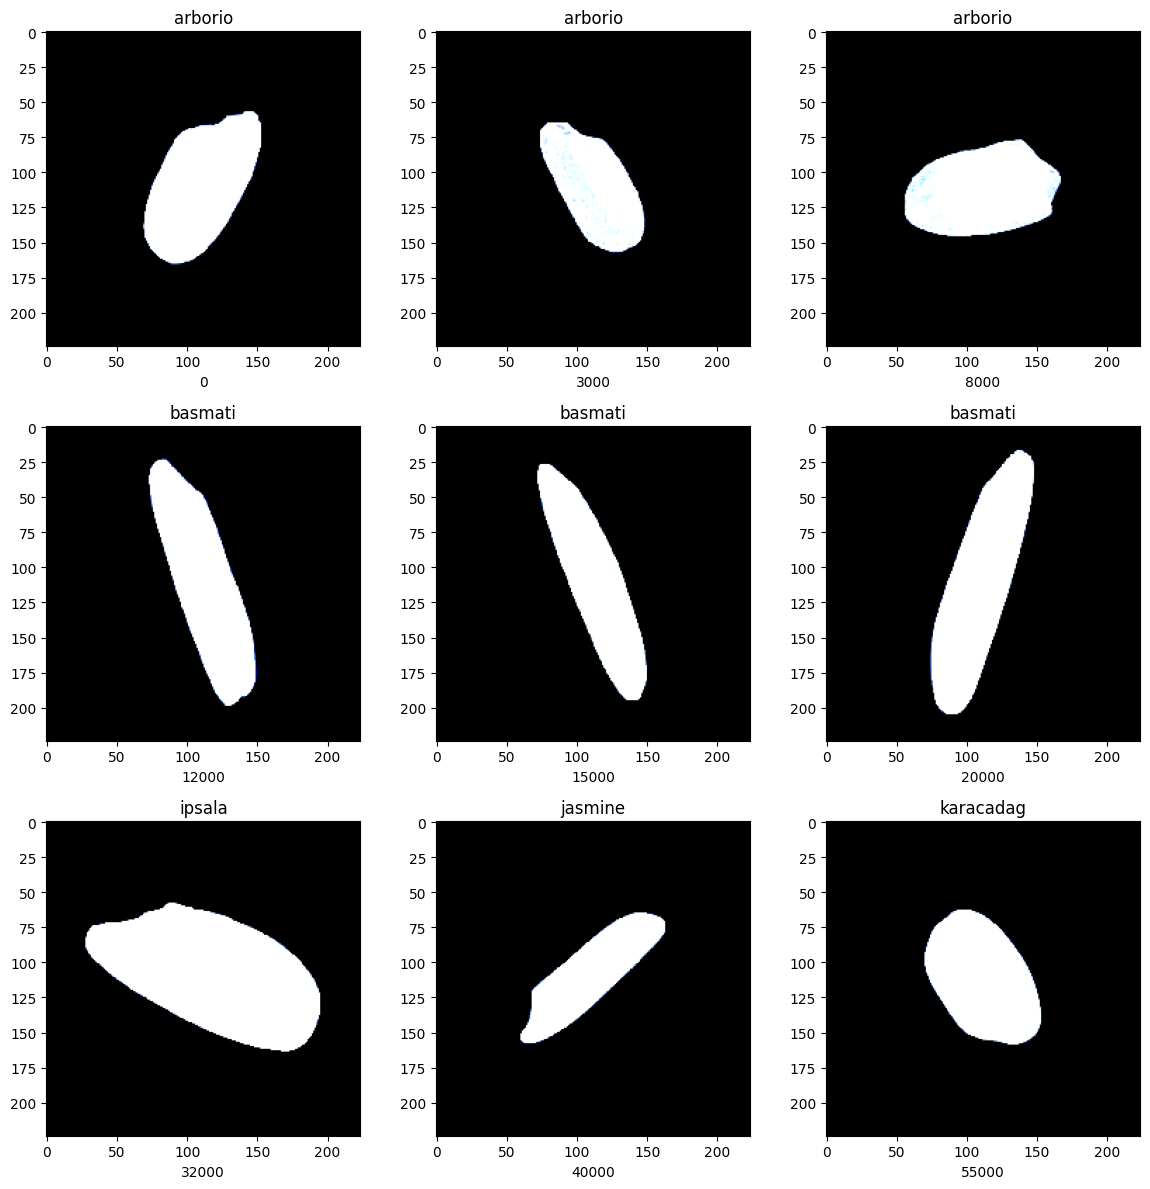

In [15]:
from PIL import Image

# Define class names
class_names = ['arborio', 'basmati', 'ipsala', 'jasmine', 'karacadag']

def show_image(image, label):
    # Convert string label to index if necessary
    if isinstance(label, str):
        label = class_names.index(label)  # Convert string to index
    print("Label: " + class_names[label] + " (" + str(label) + ")")
    plt.imshow(image.permute(1, 2, 0))  # Permute tensor to (H, W, C) for matplotlib

# Sample images to display
image_list = [0, 3000, 8000, 12000, 15000, 20000, 32000, 40000, 55000]

plt.figure(figsize=(12, 12))
chs = 0
for img in image_list:
    chs += 1
    plt.subplot(3, 3, chs)
    plt.tight_layout()
    plt.xlabel(img, fontsize=10)
    
    try:
        image, label = train_dataset[img]  # Get the image and label
        if isinstance(label, str):  # Handle if label is a string
            label_index = class_names.index(label)
        else:
            label_index = label  # If label is already an integer index
        
        plt.title(class_names[label_index])
        show_image(image, label)
    except IndexError:
        print(f"Index {img} is out of bounds for the dataset.")
    except Exception as e:
        print(f"An error occurred: {e}")

plt.show()

# **Device of Process**

In [16]:
# for moving data into GPU (if available)
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available:
        return torch.device("cuda")
    else:
        return torch.device("cpu")

In [17]:
def to_device(data, device):
    """Move tensor(s) to the chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    elif isinstance(data, torch.Tensor):
        return data.to(device, non_blocking=True)
    else:
        return data  # Do nothing for non-tensor data like strings

In [18]:
# for loading in the device (GPU if available else CPU)
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dataloader, device):
        self.dataloader = dataloader
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dataloader:
            yield to_device(b, self.device)
        
    def __len__(self):
        """Number of batches"""
        return len(self.dataloader)

In [19]:
device = get_default_device()
device

device(type='cuda')

In [20]:
# Moving data into GPU, WrappedDataLoader
train_dataloader = DeviceDataLoader(train_loader, device)
valid_dataloader = DeviceDataLoader(valid_loader, device)

# **CNN**

In [21]:
# for calculating the accuracy
def accuracy(outputs: torch.Tensor, labels: torch.Tensor) -> float:
    _, preds = torch.max(outputs, dim=1)
    correct = torch.sum(preds == labels).item()
    return correct / len(preds)

In [22]:

class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'valid_loss': loss.detach(), 'valid_acc': torch.tensor(acc).detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['valid_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['valid_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'valid_loss': epoch_loss.item(), 'valid_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, valid_loss: {:.4f}, valid_acc: {:.4f}".format(
            epoch, result['train_loss'], result['valid_loss'], result['valid_acc']))

In [23]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, pool: bool = False):
        super(ConvBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        self.pool = nn.MaxPool2d(2) if pool else nn.Identity()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.block(x)
        x = self.pool(x)
        return x


class CNN_NeuralNet(nn.Module):
    def __init__(self, input_size: tuple = (3, 224, 224), num_classes: int = 5):
        super(CNN_NeuralNet, self).__init__()
        self.conv1 = ConvBlock(3, 32, pool=True)
        self.conv2 = ConvBlock(32, 64, pool=True)
        # Dynamically determine the flattened size for the fully connected layer
        self._initialize_fc(input_size, num_classes)
        
    def _initialize_fc(self, input_size: tuple, num_classes: int):
        # Use a dummy input to determine the flattened size
        with torch.no_grad():
            x = torch.zeros(1, *input_size)  # Use the input size to simulate a forward pass
            x = self.conv1(x)
            x = self.conv2(x)
            flattened_size = x.view(1, -1).size(1)  # Get the flattened size dynamically

        # Define fully connected layers based on the dynamically calculated flattened size
        self.fc1 = nn.Linear(flattened_size, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)  # Dynamically flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    def training_step(self, batch: tuple) -> torch.Tensor:
        inputs, targets = batch
        outputs = self(inputs)
        loss = nn.CrossEntropyLoss()(outputs, targets)
        return loss

    def validation_step(self, batch: tuple) -> dict:
        inputs, targets = batch
        outputs = self(inputs)
        loss = nn.CrossEntropyLoss()(outputs, targets)
        acc = (outputs.argmax(dim=1) == targets).float().mean()
        return {'valid_loss': loss, 'valid_acc': acc}

    def validation_epoch_end(self, outputs: list) -> dict:
        batch_losses = [x['valid_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()  # Combine losses
        batch_accs = [x['valid_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()  # Combine accuracies
        return {'valid_loss': epoch_loss.item(), 'valid_acc': epoch_acc.item()}

    def epoch_end(self, epoch: int, result: dict):
        print(f"Epoch [{epoch}], train_loss: {result['train_loss']:.4f}, valid_loss: {result['valid_loss']:.4f}, valid_acc: {result['valid_acc']:.4f}")

In [24]:
model = CNN_NeuralNet(input_size=(3, 224, 224), num_classes=5)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

CNN_NeuralNet(
  (conv1): ConvBlock(
    (block): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): ConvBlock(
    (block): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
   

In [25]:
dummy_input = torch.randn(32, 3, 224, 224).to(device)   # Simulate a batch of 32 images with shape (3, 224, 224)
model_dummy = model(dummy_input)

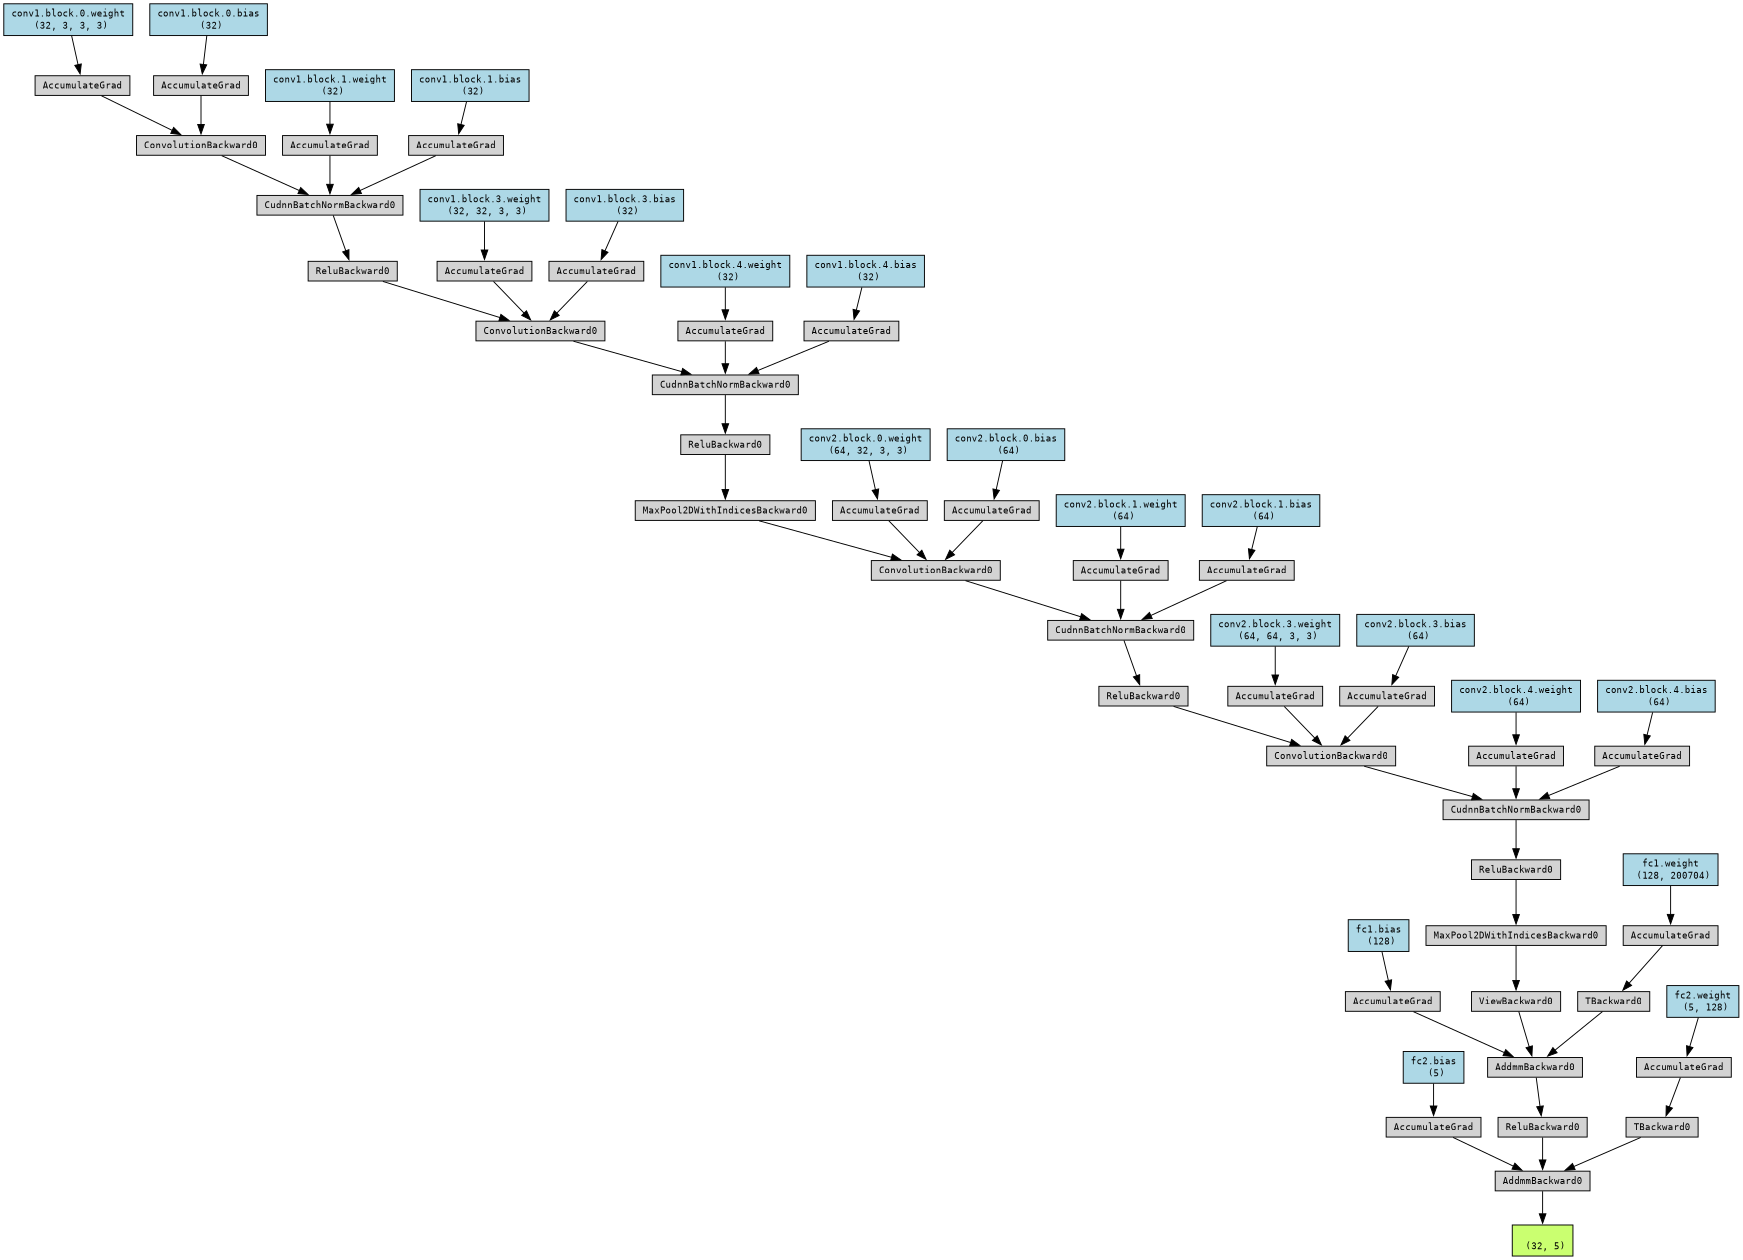

In [26]:
from torchviz import make_dot
from IPython.display import Image


# Generate the computational graph
dot = make_dot(model_dummy, params=dict(model.named_parameters()))

# Save the graph to a PNG file
dot.render("model_graph", format="png")

# Display the graph image in the notebook
Image(filename="model_graph.png")

# **Model Evaluate / Model Optimizer:**

In [27]:
@torch.no_grad()
def evaluate(model, valid_loader):
    model.eval()  # Set the model to evaluation mode
    outputs = []  # Initialize an empty list to store outputs
    for batch in valid_loader:  # Iterate over batches in the validation data loader
        inputs, targets = batch  # Unpack the batch into inputs and targets
        inputs, targets = inputs.to(device), targets.to(device)  # Move inputs and targets to the appropriate device
        output = model.validation_step((inputs, targets))  # Perform the model's validation step
        outputs.append(output)  # Append the output to the outputs list
    return model.validation_epoch_end(outputs)  # Process and return the aggregated outputs

In [28]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

# **Hyperparameters Function:**

In [29]:
def fit_OneCycle(epochs, max_lr, model, train_loader, valid_loader, weight_decay=0, grad_clip=None, opt_func=optim.SGD):
    torch.cuda.empty_cache()  # Clear cache to free memory
    history = []  # List to store results for each epoch
    
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    sched = optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        model.train()
        train_losses = []
        lrs = []
        
        for batch in train_loader:
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)
            
            loss = model.training_step((inputs, targets))
            train_losses.append(loss)
            loss.backward()
            
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                
            optimizer.step()
            optimizer.zero_grad()
            
            lrs.append(get_lr(optimizer))
            sched.step()
        
        result = evaluate(model, valid_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
        
    return history

# **Training Model:**

In [30]:
from PIL import Image 


history = fit_OneCycle(epochs=5, max_lr=1e-3, model=model, train_loader=train_loader, valid_loader=valid_loader)

# Print out the results for each epoch
for epoch_result in history:
    print(f"Epoch Results: Train Loss: {epoch_result['train_loss']:.4f}, Valid Loss: {epoch_result['valid_loss']:.4f}, Valid Acc: {epoch_result['valid_acc']:.4f}")
    


Epoch [0], train_loss: 0.0847, valid_loss: 0.0210, valid_acc: 0.9950
Epoch [1], train_loss: 0.0245, valid_loss: 0.0424, valid_acc: 0.9868
Epoch [2], train_loss: 0.0142, valid_loss: 0.0110, valid_acc: 0.9971
Epoch [3], train_loss: 0.0071, valid_loss: 0.0100, valid_acc: 0.9963
Epoch [4], train_loss: 0.0037, valid_loss: 0.0091, valid_acc: 0.9979
Epoch Results: Train Loss: 0.0847, Valid Loss: 0.0210, Valid Acc: 0.9950
Epoch Results: Train Loss: 0.0245, Valid Loss: 0.0424, Valid Acc: 0.9868
Epoch Results: Train Loss: 0.0142, Valid Loss: 0.0110, Valid Acc: 0.9971
Epoch Results: Train Loss: 0.0071, Valid Loss: 0.0100, Valid Acc: 0.9963
Epoch Results: Train Loss: 0.0037, Valid Loss: 0.0091, Valid Acc: 0.9979


# **Result**

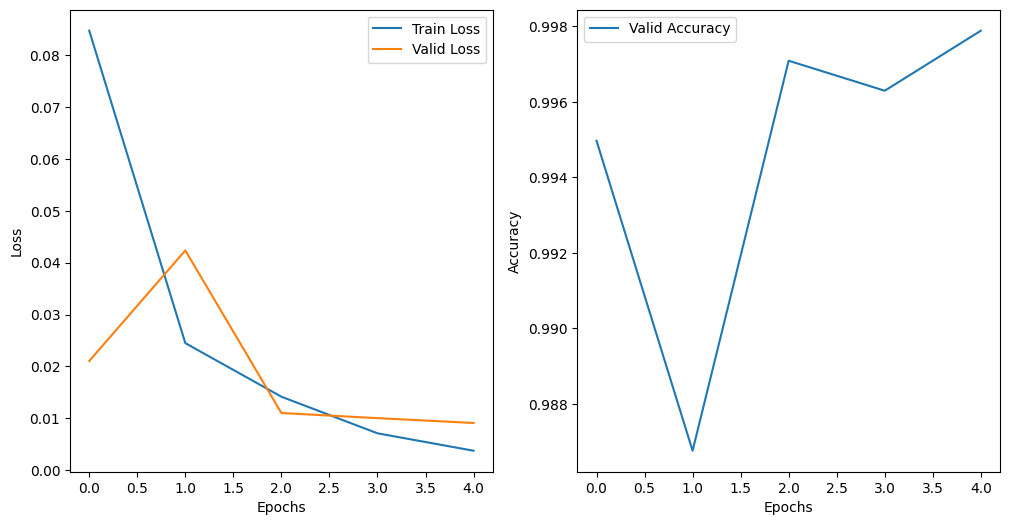

In [31]:
# Plot the training/validation loss and accuracy
import matplotlib.pyplot as plt

epochs = range(len(history))
train_losses = [x['train_loss'] for x in history]
valid_losses = [x['valid_loss'] for x in history]
valid_accuracies = [x['valid_acc'] for x in history]

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, valid_losses, label='Valid Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, valid_accuracies, label='Valid Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Epoch Results: Train Loss: 0.0847, Valid Loss: 0.0210, Valid Acc: 0.9950
Epoch Results: Train Loss: 0.0245, Valid Loss: 0.0424, Valid Acc: 0.9868
Epoch Results: Train Loss: 0.0142, Valid Loss: 0.0110, Valid Acc: 0.9971
Epoch Results: Train Loss: 0.0071, Valid Loss: 0.0100, Valid Acc: 0.9963
Epoch Results: Train Loss: 0.0037, Valid Loss: 0.0091, Valid Acc: 0.9979


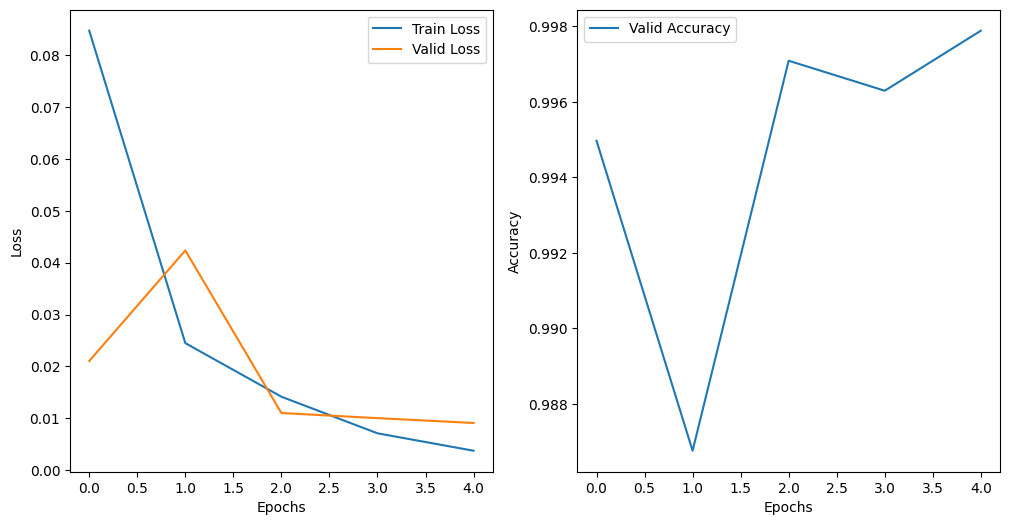

In [32]:

# Print out the results for each epoch
for epoch_result in history:
    print(f"Epoch Results: Train Loss: {epoch_result['train_loss']:.4f}, Valid Loss: {epoch_result['valid_loss']:.4f}, Valid Acc: {epoch_result['valid_acc']:.4f}")
    
# Optionally, plot the training/validation loss and accuracy
import matplotlib.pyplot as plt

epochs = range(len(history))
train_losses = [x['train_loss'] for x in history]
valid_losses = [x['valid_loss'] for x in history]
valid_accuracies = [x['valid_acc'] for x in history]

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, valid_losses, label='Valid Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, valid_accuracies, label='Valid Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

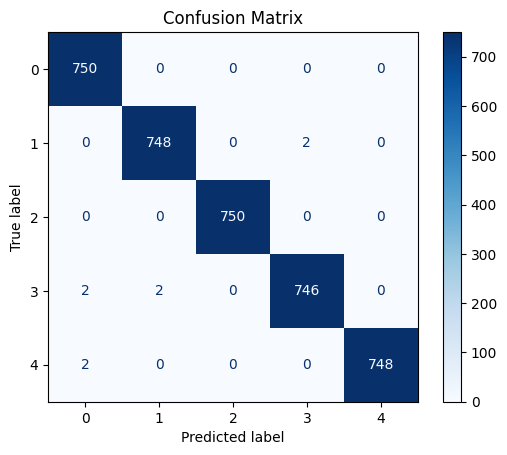

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Assuming you have the true labels and predictions
true_labels = np.concatenate([y.cpu().numpy() for x, y in valid_loader], axis=0)
predictions = np.concatenate([model(x.to(device)).argmax(dim=1).cpu().numpy() for x, y in valid_loader], axis=0)

cm = confusion_matrix(true_labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [34]:

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Set the model to evaluation mode
model.eval()

# Collect predictions
all_preds = []
all_labels = []

with torch.no_grad():  # Disable gradient calculation
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)  # Move data to the same device as the model
        preds = model(xb).argmax(dim=1)  # Get the index of the max log-probability
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(yb.cpu().numpy())

# Convert lists to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Optionally, you can print or save the predictions
print("Predictions:", all_preds)
print("True Labels:", all_labels)

# You can also calculate accuracy or other metrics
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {accuracy:.4f}")

Predictions: [0 0 0 ... 4 4 4]
True Labels: [0 0 0 ... 4 4 4]
Test Accuracy: 0.9970


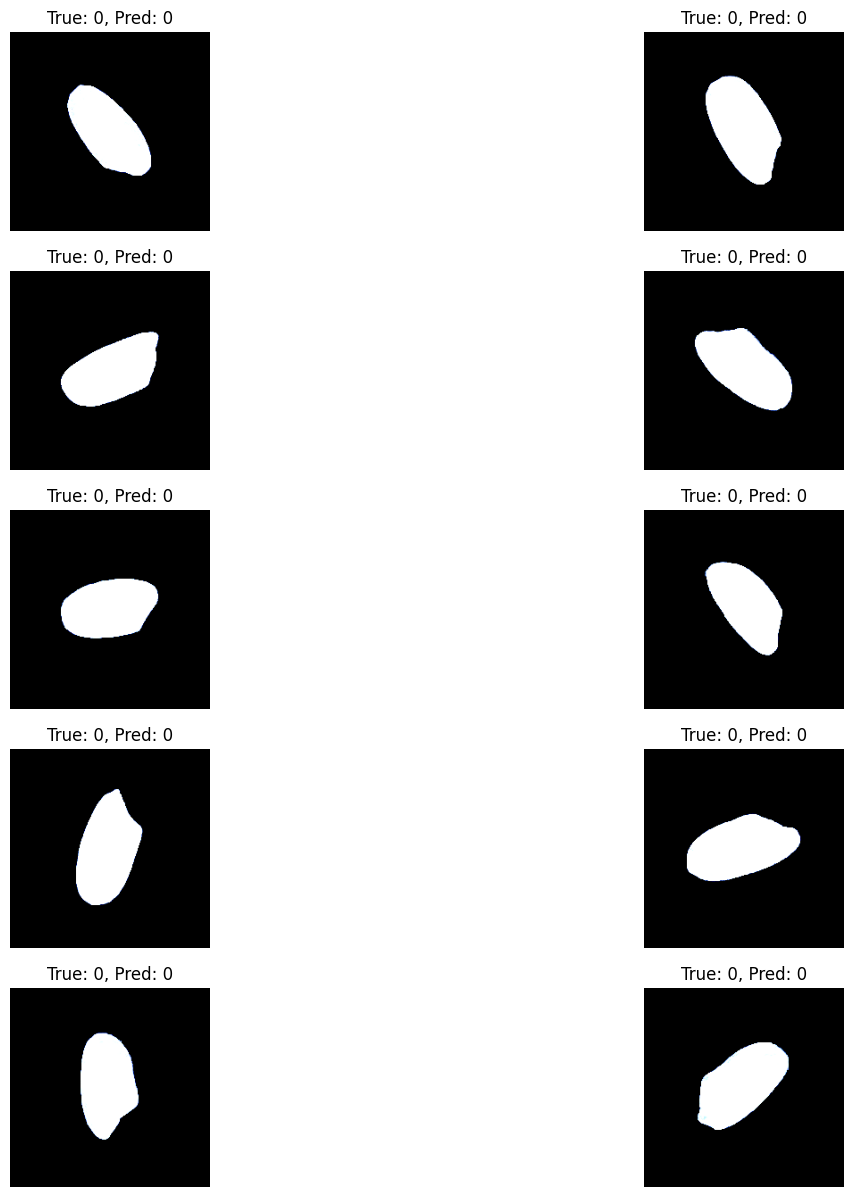

Predictions: [0 0 0 ... 4 4 4]
True Labels: [0 0 0 ... 4 4 4]
Test Accuracy: 0.9970


In [35]:

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Set the model to evaluation mode
model.eval()

# Collect predictions and visualize some images
all_preds = []
all_labels = []
images = []

with torch.no_grad():  # Disable gradient calculation
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)  # Move data to the same device as the model
        preds = model(xb).argmax(dim=1)  # Get the index of the max log-probability
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(yb.cpu().numpy())
        images.extend(xb.cpu().numpy())

# Convert lists to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
images = np.array(images)

# Visualize some test images with their predicted and true labels
num_images_to_show = 10
plt.figure(figsize=(15, 15))
for i in range(num_images_to_show):
    plt.subplot(5, 2, i + 1)
    plt.imshow(images[i].transpose((1, 2, 0)))  # Assuming images are in CHW format
    plt.title(f"True: {all_labels[i]}, Pred: {all_preds[i]}")
    plt.axis('off')
plt.show()

# Optionally, you can print or save the predictions
print("Predictions:", all_preds)
print("True Labels:", all_labels)

# You can also calculate accuracy or other metrics
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {accuracy:.4f}")

In [36]:
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Set the model to evaluation mode
model.eval()

# Collect predictions and true labels
all_preds = []
all_labels = []

with torch.no_grad():  # Disable gradient calculation
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)  # Move data to the same device as the model
        preds = model(xb).argmax(dim=1)  # Get the index of the max log-probability
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(yb.cpu().numpy())

# Convert lists to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Save predictions and true labels to a CSV file
df = pd.DataFrame({
    'True Label': all_labels,
    'Predicted Label': all_preds
})
df.to_csv('test_predictions.csv', index=False)

print("Predictions saved to test_predictions.csv")

Predictions saved to test_predictions.csv
